# Controller

In [7]:
import sys
sys.path.append('..')

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [8]:
from ctrl.linear import Gain, Feedback, Differentiator, TransferFunction, PID
from ctrl.logger import Logger

In [9]:
#from ctrl.sim import Controller

In [10]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
controller = Controller(host = HOST, port = PORT)

## Open Loop

In [11]:
a = 17   # 1/s
k = 0.11 # counts/s duty
Ts = 0.01
controller = Controller(period = Ts)

In [12]:
controller.add_sink('logger', Logger(), 
                    ['clock','encoder1'])

In [13]:
print(controller.info('all'))

> Controller with 3 signal(s), 1 source(s), 1 sink(s), and 1 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. motor1
> sources
  1. clock[enabled] >> clock
> filters
  1. motor1 >> model1[enabled] >> encoder1
> sinks
  1. clock, encoder1 >> logger[enabled]



In [14]:
controller.set_sink('logger','reset')
with controller:
    time.sleep(1)
    controller.set_signal('motor1', 100)
    time.sleep(1)
    controller.set_signal('motor1', -100)
    time.sleep(1)
    controller.set_signal('motor1', 0)
    time.sleep(1)

In [15]:
log = controller.read_sink('logger')

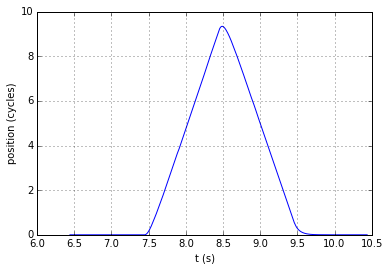

In [16]:
t = log[:,0]
position = log[:,1]
plt.plot(t, position)
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

## Closed-loop on Position
### Proportional Control

In [17]:
controller.add_signal('reference1')

In [18]:
pmax = 2
Kp = 10/k

controller.add_filter('controller1', 
                      Feedback(gamma = pmax, block = Gain(gain = Kp)),
                      ['encoder1', 'reference1'], 
                      ['motor1'])

In [19]:
controller.set_sink('logger', 'inputs',
                    ['clock', 'encoder1', 'reference1', 'motor1'])
print(controller.info('all'))

> Controller with 4 signal(s), 1 source(s), 1 sink(s), and 2 filter(s)
> period = 0.01s
> signals
  1. encoder1
  2. clock
  3. motor1
  4. reference1
> sources
  1. clock[disabled] >> clock
> filters
  1. motor1 >> model1[enabled] >> encoder1
  2. encoder1, reference1 >> controller1[enabled] >> motor1
> sinks
  1. clock, encoder1, reference1, motor1 >> logger[enabled]



In [20]:
controller.set_sink('logger','reset')
with controller:
    time.sleep(1)
    controller.set_signal('reference1', 100)
    time.sleep(3)
    controller.set_signal('reference1', 50)
    time.sleep(3)
    controller.set_signal('reference1', -50)
    time.sleep(3)
log = controller.read_sink('logger')

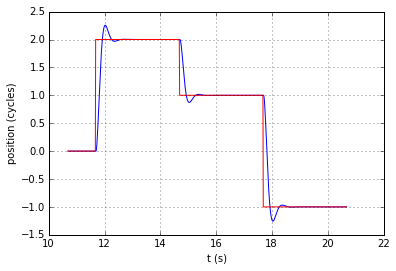

In [21]:
t = log[:,0]
position = log[:,1]
reference = log[:,2]

plt.plot(t, position, '-b', t, pmax*reference/100, 'r-')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

### Calculate velocity

In [22]:
controller.add_signal('velocity1')
controller.add_filter('differentiator1', Differentiator(),
                      ['clock', 'encoder1'], 
                      ['velocity1'])

In [23]:
controller.set_sink('logger', 'inputs',
                    ['clock', 'encoder1', 'reference1', 'motor1', 'velocity1'])
print(controller.info('all'))

> Controller with 5 signal(s), 1 source(s), 1 sink(s), and 3 filter(s)
> period = 0.01s
> signals
  1. velocity1
  2. encoder1
  3. clock
  4. motor1
  5. reference1
> sources
  1. clock[disabled] >> clock
> filters
  1. motor1 >> model1[enabled] >> encoder1
  2. encoder1, reference1 >> controller1[enabled] >> motor1
  3. clock, encoder1 >> differentiator1[enabled] >> velocity1
> sinks
  1. clock, encoder1, reference1, motor1, velocity1 >> logger[enabled]



In [24]:
controller.set_sink('logger','reset')
with controller:
    time.sleep(1)
    controller.set_signal('reference1', 100)
    time.sleep(3)
    controller.set_signal('reference1', 50)
    time.sleep(3)
    controller.set_signal('reference1', -50)
    time.sleep(3)
log = controller.read_sink('logger')

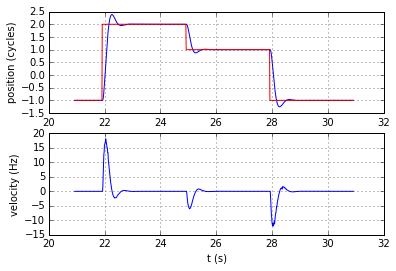

In [25]:
t = log[:,0]
position = log[:,1]
reference = log[:,2]
velocity = log[:,4]

plt.subplot(2,1,1)
plt.plot(t, position, '-b', t, pmax*reference/100, 'r-')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, velocity, 'b-')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

## Closed-loop on Velocity
### Proportional Control

In [26]:
vmax = 11
Kp = 1/k
controller.remove_filter('controller1') 
controller.add_filter('controller1', 
                      Feedback(gamma = vmax, block = Gain(gain = Kp)),
                      ['velocity1', 'reference1'], 
                      ['motor1'])

In [27]:
print(controller.info('all'))

> Controller with 5 signal(s), 1 source(s), 1 sink(s), and 3 filter(s)
> period = 0.01s
> signals
  1. velocity1
  2. motor1
  3. encoder1
  4. clock
  5. reference1
> sources
  1. clock[disabled] >> clock
> filters
  1. motor1 >> model1[enabled] >> encoder1
  2. clock, encoder1 >> differentiator1[enabled] >> velocity1
  3. velocity1, reference1 >> controller1[enabled] >> motor1
> sinks
  1. clock, encoder1, reference1, motor1, velocity1 >> logger[enabled]



In [28]:
controller.set_sink('logger','reset')
controller.set_signal('reference1', 0)
with controller:
    time.sleep(1)
    controller.set_signal('reference1', 100)
    time.sleep(3)
    controller.set_signal('reference1', 50)
    time.sleep(3)
    controller.set_signal('reference1', -50)
    time.sleep(3)
log = controller.read_sink('logger')

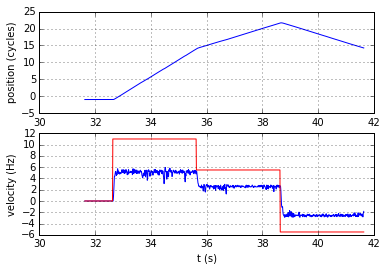

In [29]:
t = log[:,0]
position = log[:,1]
reference = log[:,2]
velocity = log[:,4]

plt.subplot(2,1,1)
plt.plot(t, position, '-b')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, velocity, 'b-', t, vmax*reference/100, 'r-')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

## Closed-loop on Velocity
### Proportional-Integral Control

In [30]:
Kp = 1/k
Ki = a/k
controller.remove_filter('controller1') 
pi = TransferFunction(model = PID(Kp = Kp, Ki = Ki, period = controller.period))
controller.add_filter('controller1', 
                      Feedback(gamma = vmax, block = pi),
                      ['velocity1', 'reference1'], 
                      ['motor1'])
print(controller.info('all'))

> Controller with 5 signal(s), 1 source(s), 1 sink(s), and 3 filter(s)
> period = 0.01s
> signals
  1. velocity1
  2. motor1
  3. encoder1
  4. clock
  5. reference1
> sources
  1. clock[disabled] >> clock
> filters
  1. motor1 >> model1[enabled] >> encoder1
  2. clock, encoder1 >> differentiator1[enabled] >> velocity1
  3. velocity1, reference1 >> controller1[enabled] >> motor1
> sinks
  1. clock, encoder1, reference1, motor1, velocity1 >> logger[enabled]



In [31]:
controller.set_signal('reference1', 0)
with controller:
    time.sleep(1)
    controller.set_signal('reference1', 100)
    time.sleep(3)
    controller.set_signal('reference1', 50)
    time.sleep(3)
    controller.set_signal('reference1', -50)
    time.sleep(3)
log = controller.read_sink('logger')

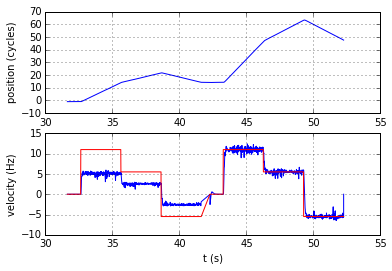

In [32]:
t = log[:,0]
position = log[:,1]
reference = log[:,2]
velocity = log[:,4]

plt.subplot(2,1,1)
plt.plot(t, position, '-b')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

plt.subplot(2,1,2)
plt.plot(t, velocity, 'b-', t, vmax*reference/100, 'r-')
plt.xlabel('t (s)')
plt.ylabel('velocity (Hz)')
plt.grid()

### Closed-loop on Velocity (PI Control) Asynchronous

In [33]:
controller.set_sink('logger','reset')

In [34]:
controller.start()
controller.set_signal('reference1', 100)

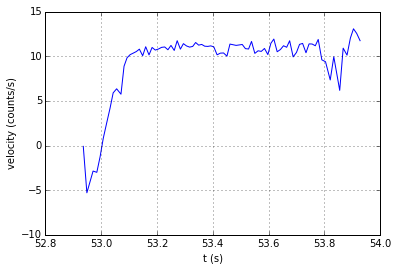

In [35]:
time.sleep(1)
log = controller.read_sink('logger')

t = log[:,0]
reference = log[:,2]
velocity = log[:,4]

plt.plot(t, velocity)
plt.xlabel('t (s)')
plt.ylabel('velocity (counts/s)')
plt.grid()

In [36]:
controller.stop()